In [ ]:
#  KÜTÜPHANELER
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Keras & TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

kok_dizin = "C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data"
bulunan_train_yolu = ""
bulunan_test_yolu = ""


for root, dirs, files in os.walk(kok_dizin):
    if "train" in dirs and "sign_data" in root: 
        bulunan_train_yolu = os.path.join(root, "train")
        bulunan_test_yolu = os.path.join(root, "test")
        print(f" Klasör bulundu: {bulunan_train_yolu}")
        break

if bulunan_train_yolu == "":
    print(" Otomatik bulunamadı, varsayılan deneniyor...")
    bulunan_train_yolu = "C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data/train"
    bulunan_test_yolu = "C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data/test"

TRAIN_DIR = bulunan_train_yolu
TEST_DIR = bulunan_test_yolu

base_csv_dir = os.path.dirname(TRAIN_DIR) 
train_csv_path = os.path.join(base_csv_dir, "train_data.csv")
test_csv_path = os.path.join(base_csv_dir, "test_data.csv")

print(f"Eğitim Klasörü: {TRAIN_DIR}")
print(f"CSV Dosyası: {train_csv_path}")

 Klasör bulundu: C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data\train
Eğitim Klasörü: C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data\train
CSV Dosyası: C:/Users/murat/OneDrive/Masaüstü/Datasetler/sign_data/sign_data\train_data.csv


In [ ]:
#   VERİ YÜKLEYİCİ 

class VeriYukleyici:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir

    def karistir(self):
        return self.dataset.sample(frac=1).reset_index(drop=True)

    def veri_ureteci(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.karistir()
            for batch in range(0, num_samples, self.batch_size):
                resim1_listesi = self.dataset.iloc[:, 0][batch:batch + self.batch_size]
                resim2_listesi = self.dataset.iloc[:, 1][batch:batch + self.batch_size]
                etiket_listesi = self.dataset.iloc[:, 2][batch:batch + self.batch_size]
                
                Resim1, Resim2, Etiket = [], [], []
                
                for r1, r2, etiket in zip(resim1_listesi, resim2_listesi, etiket_listesi):
                    try:

                        r1_path = os.path.join(self.dir, str(r1))
                        r2_path = os.path.join(self.dir, str(r2))
                        
                        # Dosya kontrolu
                        if not os.path.exists(r1_path) or not os.path.exists(r2_path):
                            continue

                        img1 = Image.open(r1_path).convert('RGB').resize((112, 112))
                        img2 = Image.open(r2_path).convert('RGB').resize((112, 112))
                        
                        Resim1.append(img_to_array(img1) /255.0)
                        Resim2.append(img_to_array(img2) /255.0)
                        Etiket.append(1-etiket)
                    except Exception as e:
                        continue

                if len(Resim1) == 0:
                    continue

            
                yield (
                    (np.array(Resim1, dtype=np.float32), np.array(Resim2, dtype=np.float32)),
                    np.array(Etiket, dtype=np.float32)
                )

print("Veri Yükleyici sınıfı güncellendi")

Veri Yükleyici sınıfı güncellendi


In [ ]:
#SİYAM AĞI MİMARİSİ

def imza_dogrulama_modeli(input_shape):
    
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    
    cnn_model = Sequential()
    
    cnn_model.add(Input(shape=input_shape)) 
    
    cnn_model.add(Conv2D(16, (3,3), activation='relu'))
    cnn_model.add(MaxPooling2D(2,2))
    cnn_model.add(Dropout(0.25)) 

    cnn_model.add(Conv2D(32, (3,3), activation='relu'))
    cnn_model.add(MaxPooling2D(2,2))
    cnn_model.add(Dropout(0.25))

    cnn_model.add(Conv2D(64, (3,3), activation='relu'))
    cnn_model.add(MaxPooling2D(2,2))
    cnn_model.add(Dropout(0.25))
    
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    
    ozellik1 = cnn_model(input1)
    ozellik2 = cnn_model(input2)

    # Karşılaştırma
    mesafe = Lambda(lambda t: tf.math.abs(t[0] - t[1]), output_shape=(128,))([ozellik1, ozellik2])
    
    # Çıktı
    cikis = Dense(1, activation='sigmoid')(mesafe)
    
    network = Model(inputs=[input1, input2], outputs=cikis)
    return network

model = imza_dogrulama_modeli((112,112,3))
model.summary()

Model: "functional_83"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 128)       │  1,203,360 │ input_layer_18[0… │
│ (Sequential)        │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 128)       │          0 │ sequential_6[0][… │
│                     │                   │            │ sequential_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │        129 │ lambda_6[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,203,489 (4.59 MB)

 Trainable params: 1,203,489 (4.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# EĞİTİM BAŞLATMA
import tensorflow as tf

train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(test_csv_path)

batch_size = 64
egitim_gen_sinifi = VeriYukleyici(train_df, batch_size, TRAIN_DIR)
dogrulama_gen_sinifi = VeriYukleyici(val_df, batch_size, TEST_DIR)

output_signature = (
    (
        tf.TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32), 
        tf.TensorSpec(shape=(None, 112, 112, 3), dtype=tf.float32)
    ),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

train_ds = tf.data.Dataset.from_generator(
    egitim_gen_sinifi.veri_ureteci,
    output_signature=output_signature
)

val_ds = tf.data.Dataset.from_generator(
    dogrulama_gen_sinifi.veri_ureteci,
    output_signature=output_signature
)

# Modeli Eğitme
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

print("Eğitim başlıyor")

history = model.fit(
    train_ds,
    steps_per_epoch=20,
    epochs=30,
    validation_data=val_ds,
    validation_steps=10,
    callbacks=[early_stopper]
)
model.save("imza_modeli.h5")
print("Model başarıyla kaydedildi!")

Eğitim başlıyor
Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5469 - loss: 0.6904 - val_accuracy: 0.5031 - val_loss: 0.6952
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5555 - loss: 0.6899 - val_accuracy: 0.5016 - val_loss: 0.6958
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5227 - loss: 0.6940 - val_accuracy: 0.4734 - val_loss: 0.6946
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 947ms/step - accuracy: 0.5414 - loss: 0.6876 - val_accuracy: 0.4891 - val_loss: 0.6958
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 777ms/step - accuracy: 0.5344 - loss: 0.6937 - val_accuracy: 0.4797 - val_loss: 0.6955
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 780ms/step - accuracy: 0.5359 - loss: 0.6922 - val_accuracy: 0.4797 - val_loss: 0.6952
Epoch 6: early stopping


Model başarıyla kaydedildi!


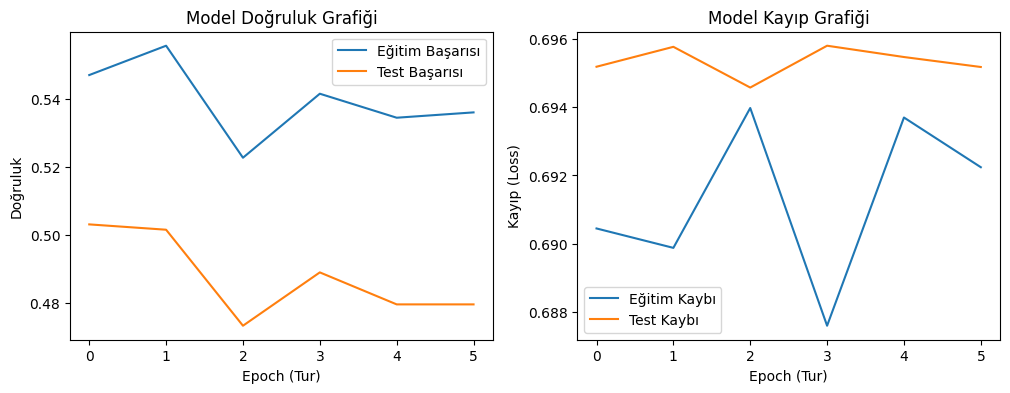

In [41]:
# HÜCRE 5: SONUÇ GRAFİKLERİ 
plt.figure(figsize=(12, 4))

# Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
plt.plot(history.history['val_accuracy'], label='Test Başarısı')
plt.title('Model Doğruluk Grafiği')
plt.xlabel('Epoch (Tur)')
plt.ylabel('Doğruluk')
plt.legend()

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Test Kaybı')
plt.title('Model Kayıp Grafiği')
plt.xlabel('Epoch (Tur)')
plt.ylabel('Kayıp (Loss)')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


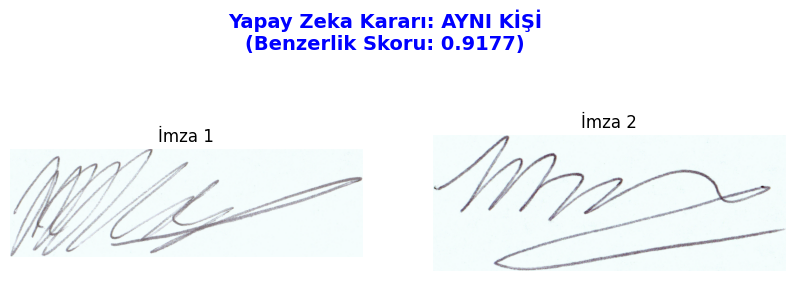

In [ ]:
# HÜCRE 6: ÇIKIŞ

def testi_gorsellestir():
    # Test veri setinden rastgele satır
    rastgele_secim = val_df.sample(1).iloc[0]
    img1_path = os.path.join(TEST_DIR, rastgele_secim[0])
    img2_path = os.path.join(TEST_DIR, rastgele_secim[1])
    gercek_etiket = rastgele_secim[2]
    
    # Resimleri hazırla
    img1_org = Image.open(img1_path)
    img2_org = Image.open(img2_path)
    
    img1 = img_to_array(img1_org.resize((112, 112)))
    img2 = img_to_array(img2_org.resize((112, 112)))
    
    img1_batch = np.expand_dims(img1, axis=0)
    img2_batch = np.expand_dims(img2, axis=0)

    tahmin_skoru = model.predict([img1_batch, img2_batch])[0][0]
    
    karar = "AYNI KİŞİ" if tahmin_skoru > 0.5 else "FARKLI KİŞİLER" 
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img1_org)
    plt.title("İmza 1")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2_org)
    plt.title("İmza 2")
    plt.axis('off')
    
    plt.suptitle(f"Yapay Zeka Kararı: {karar}\n(Benzerlik Skoru: {tahmin_skoru:.4f})", 
                 fontsize=14, color='blue', weight='bold')
    plt.show()

testi_gorsellestir()